Model: "functional_141"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_142 (InputLayer)          [(None, 7, 7, 256)]  0                                            
__________________________________________________________________________________________________
input_143 (InputLayer)          [(None, 7, 7, 256)]  0                                            
__________________________________________________________________________________________________
flatten_141 (Flatten)           (None, 12544)        0           input_142[0][0]                  
__________________________________________________________________________________________________
flatten_142 (Flatten)           (None, 12544)        0           input_143[0][0]                  
_____________________________________________________________________________________

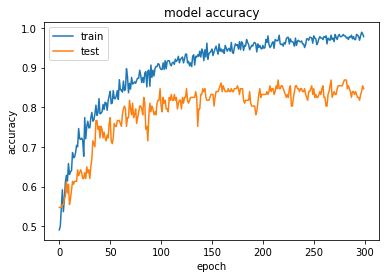

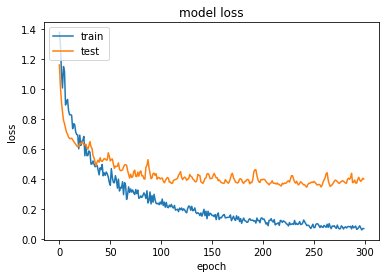

In [134]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

xs_face = np.load("saved_data/no_pose/xs_face_no_pose.npy")
xs = np.load("saved_data/no_pose/xs_no_pose.npy")
ys = np.load("saved_data/no_pose/ys_no_pose.npy")

xs_face_train, xs_face_test, xs_train, xs_test, ys_train, ys_test  = train_test_split(xs_face, xs, ys, test_size=0.2, random_state=42)
# Face.
faceInput = keras.layers.Input(shape=(7,7,256,))
flattenFace = keras.layers.Flatten()(faceInput)
denseFace = keras.layers.Dense(128, activation='relu')(flattenFace)
denseFace = BatchNormalization()(denseFace)
denseFace = keras.layers.Dropout(0.5)(denseFace)


# Pose.
embedInput = keras.layers.Input(shape=(7,7,256,))
flattenEmbed = keras.layers.Flatten()(embedInput)
denseEmbed = keras.layers.Dense(128, activation='relu')(flattenEmbed)
denseEmbed = BatchNormalization()(denseEmbed)
denseEmbed = keras.layers.Dropout(0.5)(denseEmbed)


# Concat feature and pass to output layer.
merged = keras.layers.Concatenate(axis=1)([denseFace, denseEmbed])
merged = keras.layers.Dense(32, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = keras.layers.Dropout(0.5)(merged)

output = keras.layers.Dense(2, activation='softmax', use_bias=False)(merged)
model = keras.models.Model(inputs=[faceInput, embedInput], outputs=output)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
              metrics=['accuracy'])
model.summary()
history = model.fit(
    [xs_face_train, xs_train], 
    ys_train, 
    batch_size=32, 
    epochs=300,
    validation_data=([xs_face_test, xs_test], ys_test)
)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [135]:
model.save("./saved_models/no_pose_affectnet_model")

INFO:tensorflow:Assets written to: ./saved_models/no_pose_affectnet_model/assets
